In [1]:
import numpy as np
import sklearn.preprocessing
import torch
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt 
import random
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset, SubsetRandomSampler
import os
import json
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import pandas as pd
from time import time
from torchvision.datasets import ImageFolder
from torch import as_strided


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
train_ds = np.load('./NYC-stdn/volume_train.npz')['volume']
test_ds = np.load('./NYC-stdn/volume_test.npz')['volume']

In [3]:
print(train_ds.shape)
print(test_ds.shape)
print(test_ds.dtype)
print(train_ds.dtype)

(1920, 10, 20, 2)
(960, 10, 20, 2)
float64
float64


In [4]:
train_ds = train_ds.reshape(train_ds.shape[0], -1, train_ds.shape[3])
test_ds = test_ds.reshape(test_ds.shape[0], -1, test_ds.shape[3])
print(train_ds.shape)
print(test_ds.shape)

(1920, 200, 2)
(960, 200, 2)


In [5]:
def mean_std_normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    normalized = (tensor - mean) / (std + 1e-6)
    return normalized, mean, std  # 返回归一化数据和参数

In [12]:
def mean_std_denormalize(normalized_tensor, mean, std):
    return normalized_tensor * std + mean

In [7]:
train_ds = torch.from_numpy(train_ds)
test_ds = torch.from_numpy(test_ds)
train_scaler = torch.zeros(train_ds.shape)
test_scaler = torch.zeros(test_ds.shape)
# 归一化
train_scaler[:,:,0], train_mean_i, train_std_i = mean_std_normalize(train_ds[:,:,0])
train_scaler[:,:,1], train_mean_o, train_std_o = mean_std_normalize(train_ds[:,:,1])

test_scaler[:,:,0], test_mean_i, test_std_i = mean_std_normalize(test_ds[:,:,0])
test_scaler[:,:,1], test_mean_o, test_std_o = mean_std_normalize(test_ds[:,:,1])

# 划分训练数据集，验证数据集，测试数据集
train_proportion, val_proportion = 0.8, 0.2
train_dataset = train_scaler[:int(train_proportion * len(train_ds)),:,:]
val_dataset = train_scaler[int(train_proportion * len(train_ds)):,:,:]


In [8]:
class TrafficDataset(Dataset):
    def __init__(self, dataset, window_size, pred_len):
        self.window_size = window_size
        self.pred_len = pred_len
        self.dataset = dataset
        self.T, self.N, self.F = self.dataset.shape  # 时间步，节点数，特征数
    
    def __len__(self):
        return self.T - self.window_size - self.pred_len
    
    def __getitem__(self, idx):
        x = self.dataset[idx:idx + self.window_size, :]
        y = self.dataset[idx + self.window_size:idx + self.window_size + self.pred_len, :]
        x = torch.FloatTensor(x)  # shape: (window_size, N, F)
        y = torch.FloatTensor(y)  # shape: (pred_len, N, F)
        x = x.view(self.window_size, -1)
        y = y.view(self.pred_len, -1)
        return x, y

In [9]:
train_ds = TrafficDataset(train_dataset, window_size=6, pred_len=1)
val_ds = TrafficDataset(val_dataset, window_size=6, pred_len=1)
test_ds = TrafficDataset(test_scaler, window_size=6, pred_len=1)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=False)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [10]:
for i, (x, y) in enumerate(test_dl):
    print(x.dtype)
    print(y.shape)
    break
    

torch.float32
torch.Size([32, 1, 400])


In [28]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct, flag=True):
    loss_list = []
    rmse_list_i = []
    mae_list_i = []
    rmse_list_o = []
    mae_list_o = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        hidden = model(datas)
        hidden = hidden.squeeze(0)
        # hidden = hidden[1]
        labels = labels.squeeze(1)
        loss = loss_fct(hidden, labels)         # 验证集损失
        if flag:    # 如果为True就代表是训练模式
            labels = labels.reshape(labels.shape[0], 200, 2)
            labels[:,:,0] = mean_std_denormalize(labels[:,:,0], train_mean_i, train_std_i)
            labels[:,:,1] = mean_std_denormalize(labels[:,:,1], train_mean_o, train_std_o)
            hidden = hidden.reshape(hidden.shape[0], 200, 2)
            hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], train_mean_i, train_std_i)
            hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], train_mean_o, train_std_o)
        else:
            labels = labels.reshape(labels.shape[0], 200, 2)
            labels[:,:,0] = mean_std_denormalize(labels[:,:,0], test_mean_i, test_std_i)
            labels[:,:,1] = mean_std_denormalize(labels[:,:,1], test_mean_o, test_std_o)
            hidden = hidden.reshape(hidden.shape[0], 200, 2)
            hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], test_mean_i, test_std_i)
            hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], test_mean_o, test_std_o)
        
        # # 计算数据范围
        # data_range_i = torch.max(labels[:,:,0]) - torch.min(labels[:,:,0]) 
        # # 计算相对误差率
        # relative_error_i = torch.mean(torch.abs(labels[:,:,0] - hidden[:,:,0]) / data_range_i * 100)  # 百分比
        # data_range_o = torch.max(labels[:,:,1]) - torch.min(labels[:,:,1]) 
        # # 计算相对误差率
        # relative_error_o = torch.mean(torch.abs(labels[:,:,1] - hidden[:,:,1]) / data_range_o * 100)  # 百分比
        # 
        # labels = labels.reshape(labels.shape[0], -1)
        # hidden = hidden.reshape(hidden.shape[0], -1)
        loss_list.append(loss.item())
        rmse_i = torch.sqrt(torch.mean((labels[:,:,0] - hidden[:,:,0]) ** 2))   ## 计算RMSE
        mae_i = torch.mean(torch.abs(labels - hidden)) # 计算MAE
        rmse_o = torch.sqrt(torch.mean((labels[:,:,1] - hidden[:,:,1]) ** 2))   ## 计算RMSE
        mae_o = torch.mean(torch.abs(labels - hidden)) # 计算MAE  
        rmse_list_i.append(rmse_i.item())
        mae_list_i.append(mae_i.item())
        rmse_list_o.append(rmse_o.item())
        mae_list_o.append(mae_o.item())
    return np.mean(loss_list), np.mean(rmse_list_i), np.mean(mae_list_i), np.mean(rmse_list_o), np.mean(mae_list_o)


In [29]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1e5
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [30]:
class TrafficModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        # RNN的输出是hidden_size
        self.y = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.Linear(256, output_size),
        )
        # self.y = nn.Linear(hidden_size, output_size)
                
                
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden = self.y(hidden)
        return  hidden

In [46]:
class TrafficModel2(nn.Module):
    def __init__(self):
        super().__init__()
        # 空间模块（2D CNN）
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),  # 输入6个时间步
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # 时间模块（LSTM）
        self.temporal = nn.LSTM(64*(10//2)*(20//2), 128)  # 空间下采样后尺寸
        
        # 联合预测头
        self.head = nn.Sequential(
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.Linear(256, 400)  # 输出200个区域的2个特征
        )
    
    def forward(self, x): # torch.Size([32, 6, 10, 20, 2])
        # 修改后的forward开始部分
        B, T, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3)  # (B,T,C,H,W)
        x = x.reshape(B*T, C, H, W)    # 正确输入CNN
        spatial_feat = self.spatial(x)  # (B*T, 64, H', W')
        
        # 时间处理
        temporal_in = spatial_feat.reshape(B, T, -1)  # (B, T, 64*H'*W')
        temporal_out, _ = self.temporal(temporal_in)
        
        # 预测
        return self.head(temporal_out[:, -1])  # 取最后时间步

In [43]:
# 多目标损失函数
def loss_fn(pred, target):
    mae = nn.L1Loss()(pred, target)
    mse = nn.MSELoss()(pred, target)
    return 0.7 * mae + 0.3 * mse  # 平衡误差敏感性

In [33]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    flag=True
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                hidden = model(datas)
                hidden = hidden.squeeze(0)
                # hidden = hidden[1]
                labels = labels.squeeze(1)
                # 计算损失
                loss = loss_fct(hidden, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if flag:    # 如果为True就代表是训练模式
                    labels = labels.reshape(labels.shape[0], 200, 2)
                    labels[:,:,0] = mean_std_denormalize(labels[:,:,0], train_mean_i, train_std_i)
                    labels[:,:,1] = mean_std_denormalize(labels[:,:,1], train_mean_o, train_std_o)
                    hidden = hidden.reshape(hidden.shape[0], 200, 2)
                    hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], train_mean_i, train_std_i)
                    hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], train_mean_o, train_std_o)
                else:
                    labels = labels.reshape(labels.shape[0], 200, 2)
                    labels[:,:,0] = mean_std_denormalize(labels[:,:,0], test_mean_i, test_std_i)
                    labels[:,:,1] = mean_std_denormalize(labels[:,:,1], test_mean_o, test_std_o)
                    hidden = hidden.reshape(hidden.shape[0], 200, 2)
                    hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], test_mean_i, test_std_i)
                    hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], test_mean_o, test_std_o)
                
                # # 计算数据范围
                # data_range_i = torch.max(labels[:,:,0]) - torch.min(labels[:,:,0]) 
                # # 计算相对误差率
                # relative_error_i = torch.mean(torch.abs(labels[:,:,0] - hidden[:,:,0]) / data_range_i * 100)  # 百分比
                # data_range_o = torch.max(labels[:,:,1]) - torch.min(labels[:,:,1]) 
                # # 计算相对误差率
                # relative_error_o = torch.mean(torch.abs(labels[:,:,1] - hidden[:,:,1]) / data_range_o * 100)  # 百分比
                
                # labels = labels.reshape(labels.shape[0], -1)
                # hidden = hidden.reshape(hidden.shape[0], -1)
                
                rmse_i = torch.sqrt(torch.mean((labels[:,:,0] - hidden[:,:,0]) ** 2))   ## 计算RMSE
                mae_i = torch.mean(torch.abs(labels - hidden)) # 计算MAE
                loss = loss.cpu().item() # 计算损失
                rmse_o = torch.sqrt(torch.mean((labels[:,:,1] - hidden[:,:,1]) ** 2))   ## 计算RMSE
                mae_o = torch.mean(torch.abs(labels - hidden)) # 计算MAE                

                # record
                
                record_dict["train"].append({
                    "loss": loss, "rmse_i": rmse_i.cpu().item(), "mae_i":mae_i.cpu().item(), 
                    "rmse_o":rmse_o.cpu().item(), "mae_o":mae_o.cpu().item(),
                    "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_rmse_i, val_mae_i,val_rmse_o, val_mae_o = evaluating(model, val_loader, loss_fct, flag)
                    record_dict["val"].append({
                        "loss": val_loss, "rmse_i": val_rmse_i, "mae_i":val_mae_i, "rmse_o": val_rmse_o, "mae_o":val_mae_o, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(-(val_rmse_i + val_rmse_o + val_mae_i + val_mae_o)/4)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [21]:
epoch = 1000
model = TrafficModel(400, 128, 400)
loss_fct = loss_fn
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
early_stop_callback = EarlyStopCallback(patience=5)
model = model.to(device)
record = training(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    early_stop_callback=early_stop_callback,
    eval_step=500,
    flag=True,
    )

  0%|          | 0/48000 [00:00<?, ?it/s]

Early stop at epoch 218 / global_step 10500


In [48]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating2(model, dataloader, loss_fct, flag=True):
    loss_list = []
    rmse_list_i = []
    mae_list_i = []
    rmse_list_o = []
    mae_list_o = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        datas = datas.reshape(datas.shape[0], 6, 10, 20 ,2)
        # 前向计算
        hidden = model(datas)
        hidden = hidden.squeeze(0)
        # hidden = hidden[1]
        labels = labels.squeeze(1)
        loss = loss_fct(hidden, labels)         # 验证集损失
        if flag:    # 如果为True就代表是训练模式
            labels = labels.reshape(labels.shape[0], 200, 2)
            labels[:,:,0] = mean_std_denormalize(labels[:,:,0], train_mean_i, train_std_i)
            labels[:,:,1] = mean_std_denormalize(labels[:,:,1], train_mean_o, train_std_o)
            hidden = hidden.reshape(hidden.shape[0], 200, 2)
            hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], train_mean_i, train_std_i)
            hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], train_mean_o, train_std_o)
        else:
            labels = labels.reshape(labels.shape[0], 200, 2)
            labels[:,:,0] = mean_std_denormalize(labels[:,:,0], test_mean_i, test_std_i)
            labels[:,:,1] = mean_std_denormalize(labels[:,:,1], test_mean_o, test_std_o)
            hidden = hidden.reshape(hidden.shape[0], 200, 2)
            hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], test_mean_i, test_std_i)
            hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], test_mean_o, test_std_o)
        
        # # 计算数据范围
        # data_range_i = torch.max(labels[:,:,0]) - torch.min(labels[:,:,0]) 
        # # 计算相对误差率
        # relative_error_i = torch.mean(torch.abs(labels[:,:,0] - hidden[:,:,0]) / data_range_i * 100)  # 百分比
        # data_range_o = torch.max(labels[:,:,1]) - torch.min(labels[:,:,1]) 
        # # 计算相对误差率
        # relative_error_o = torch.mean(torch.abs(labels[:,:,1] - hidden[:,:,1]) / data_range_o * 100)  # 百分比
        # 
        # labels = labels.reshape(labels.shape[0], -1)
        # hidden = hidden.reshape(hidden.shape[0], -1)
        loss_list.append(loss.item())
        rmse_i = torch.sqrt(torch.mean((labels[:,:,0] - hidden[:,:,0]) ** 2))   ## 计算RMSE
        mae_i = torch.mean(torch.abs(labels - hidden)) # 计算MAE
        rmse_o = torch.sqrt(torch.mean((labels[:,:,1] - hidden[:,:,1]) ** 2))   ## 计算RMSE
        mae_o = torch.mean(torch.abs(labels - hidden)) # 计算MAE  
        rmse_list_i.append(rmse_i.item())
        mae_list_i.append(mae_i.item())
        rmse_list_o.append(rmse_o.item())
        mae_list_o.append(mae_o.item())
    return np.mean(loss_list), np.mean(rmse_list_i), np.mean(mae_list_i), np.mean(rmse_list_o), np.mean(mae_list_o)


In [49]:
# 训练
def training2(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    eval_step=100,
    flag=True
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader: #   B, T, H, W, C
                datas = datas.to(device)
                labels = labels.to(device)
                datas = datas.reshape(datas.shape[0], 6, 10, 20 ,2)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                hidden = model(datas)
                hidden = hidden.squeeze(0)
                # hidden = hidden[1]
                labels = labels.squeeze(1)
                # 计算损失
                loss = loss_fct(hidden, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if flag:    # 如果为True就代表是训练模式
                    labels = labels.reshape(labels.shape[0], 200, 2)
                    labels[:,:,0] = mean_std_denormalize(labels[:,:,0], train_mean_i, train_std_i)
                    labels[:,:,1] = mean_std_denormalize(labels[:,:,1], train_mean_o, train_std_o)
                    hidden = hidden.reshape(hidden.shape[0], 200, 2)
                    hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], train_mean_i, train_std_i)
                    hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], train_mean_o, train_std_o)
                else:
                    labels = labels.reshape(labels.shape[0], 200, 2)
                    labels[:,:,0] = mean_std_denormalize(labels[:,:,0], test_mean_i, test_std_i)
                    labels[:,:,1] = mean_std_denormalize(labels[:,:,1], test_mean_o, test_std_o)
                    hidden = hidden.reshape(hidden.shape[0], 200, 2)
                    hidden[:,:,0] = mean_std_denormalize(hidden[:,:,0], test_mean_i, test_std_i)
                    hidden[:,:,1] = mean_std_denormalize(hidden[:,:,1], test_mean_o, test_std_o)
                
                rmse_i = torch.sqrt(torch.mean((labels[:,:,0] - hidden[:,:,0]) ** 2))   ## 计算RMSE
                mae_i = torch.mean(torch.abs(labels - hidden)) # 计算MAE
                loss = loss.cpu().item() # 计算损失
                rmse_o = torch.sqrt(torch.mean((labels[:,:,1] - hidden[:,:,1]) ** 2))   ## 计算RMSE
                mae_o = torch.mean(torch.abs(labels - hidden)) # 计算MAE                

                # record
                
                record_dict["train"].append({
                    "loss": loss, "rmse_i": rmse_i.cpu().item(), "mae_i":mae_i.cpu().item(), 
                    "rmse_o":rmse_o.cpu().item(), "mae_o":mae_o.cpu().item(),
                    "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_rmse_i, val_mae_i,val_rmse_o, val_mae_o = evaluating2(model, val_loader, loss_fct, flag)
                    record_dict["val"].append({
                        "loss": val_loss, "rmse_i": val_rmse_i, "mae_i":val_mae_i, "rmse_o": val_rmse_o, "mae_o":val_mae_o, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(-(val_rmse_i + val_rmse_o + val_mae_i + val_mae_o)/4)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [58]:
epoch = 1000
model = TrafficModel2()
loss_fct = loss_fn
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
early_stop_callback = EarlyStopCallback(patience=5)
model = model.to(device)
record = training2(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    early_stop_callback=early_stop_callback,
    eval_step=500,
    flag=True,
    )

  0%|          | 0/48000 [00:00<?, ?it/s]

Early stop at epoch 375 / global_step 18000


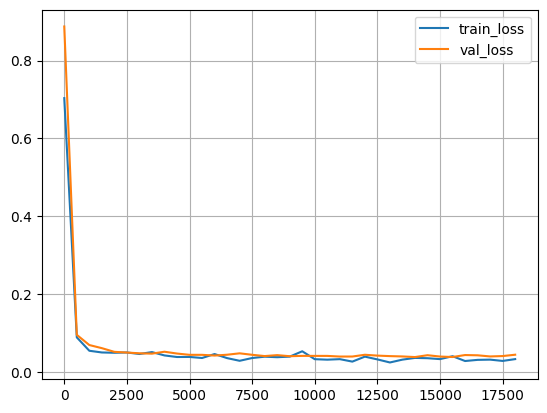

In [59]:
step = [i["step"] for i in record["train"]]
loss = [i["loss"] for i in record["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.show()

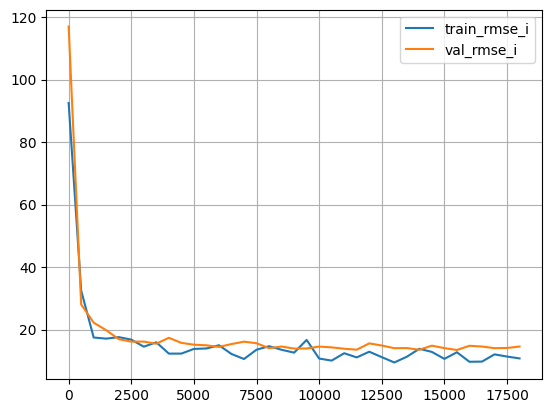

In [60]:
step = [i["step"] for i in record["train"]]
rmse_i = [i["rmse_i"] for i in record["train"]]
plt.plot(step[::500], rmse_i[::500], label="train_rmse_i")
plt.plot([i["step"] for i in record["val"]], [i["rmse_i"] for i in record["val"]], label="val_rmse_i")
plt.grid()
plt.legend()
plt.show()

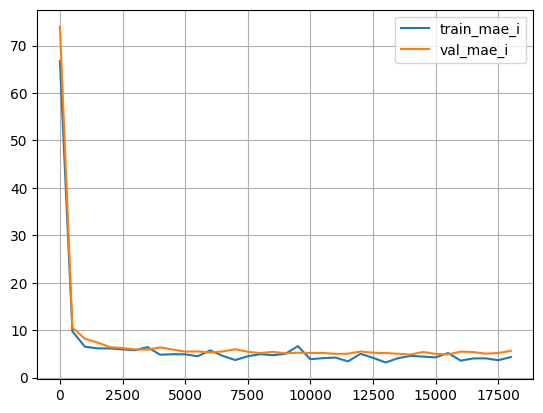

In [61]:
step = [i["step"] for i in record["train"]]
mae_i = [i["mae_i"] for i in record["train"]]
plt.plot(step[::500], mae_i[::500], label="train_mae_i")
plt.plot([i["step"] for i in record["val"]], [i["mae_i"] for i in record["val"]], label="val_mae_i")
plt.grid()
plt.legend()
plt.show()

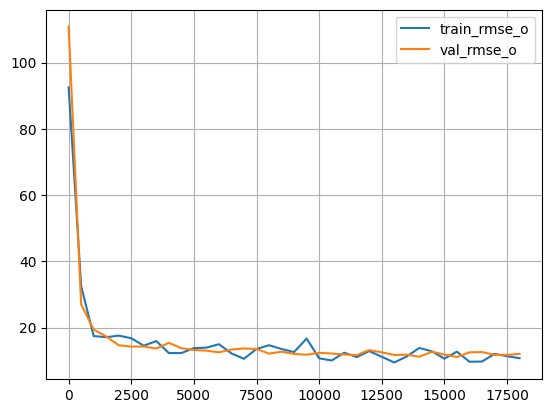

In [62]:
step = [i["step"] for i in record["train"]]
rmse_o = [i["rmse_i"] for i in record["train"]]
plt.plot(step[::500], rmse_o[::500], label="train_rmse_o")
plt.plot([i["step"] for i in record["val"]], [i["rmse_o"] for i in record["val"]], label="val_rmse_o")
plt.grid()
plt.legend()
plt.show()

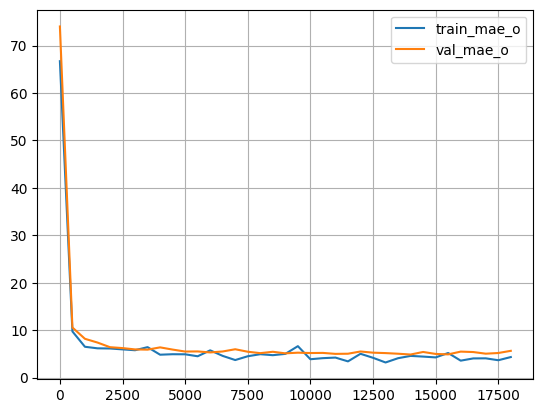

In [63]:
step = [i["step"] for i in record["train"]]
mae_o = [i["mae_o"] for i in record["train"]]
plt.plot(step[::500], mae_o[::500], label="train_mae_o")
plt.plot([i["step"] for i in record["val"]], [i["mae_o"] for i in record["val"]], label="val_mae_o")
plt.grid()
plt.legend()
plt.show()

In [64]:
model.eval()
loss, rmse_i, mae_i, rmse_o, mae_o = evaluating2(model, test_dl, loss_fct, False)
print(f"loss:     {loss:.4f}\nrmse_i: {rmse_i:.4f}\nmae_i: {mae_i:.4f}\nrmse_o:{rmse_o:.4f}\n"
      f"mae_o:{mae_o:.4f}")

loss:     0.0439
rmse_i: 16.2542
mae_i: 5.8261
rmse_o:13.5170
mae_o:5.8261


In [ ]:
loss:     5.2763
rmse: 13.8539

In [ ]:
loss:     0.0431
rmse_i: 15.4002
mae_i: 5.7887
rmse_o:12.8415
mae_o:5.7887

In [417]:
loss:     0.0439
rmse_i: 16.2542
mae_i: 5.8261
rmse_o:13.5170
mae_o:5.8261

tensor(0., dtype=torch.float64)
tensor(1149., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(1283., dtype=torch.float64)
